## References:
1. https://www.analyticsvidhya.com/blog/2021/06/music-genres-classification-using-deep-learning-techniques/
2. https://data-flair.training/blogs/python-project-music-genre-classification/
3. https://blog.clairvoyantsoft.com/music-genre-classification-using-cnn-ef9461553726
4. https://github.com/AmbarZaidi/Audio-Genre-Classification
5. https://github.com/noahunallar/music-genre-recognition-using-neural-networks-and-k-means

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Papers

1)
Automatic Musical Genre Classification Of Audio Signals
http://ismir2001.ismir.net/pdf/tzanetakis.pdf 

2) Feature Extraction for Musical Genre Classification (2015 ) with reference to 1 
http://hpac.rwth-aachen.de/teaching/sem-mus-15/reports/Merkelbach.pdf

3) SONG-LEVEL FEATURES AND SUPPORT VECTOR MACHINES FOR MUSIC CLASSIFICATION
https://www.ee.columbia.edu/~dpwe/pubs/ismir05-svm.pdf

4) Music Genre Classification
http://cs229.stanford.edu/proj2011/HaggbladeHongKao-MusicGenreClassification.pdf

### Libraries

python_speech_features
http://python-speech-features.readthedocs.io/en/latest/
https://github.com/jameslyons/python_speech_features


MFCC tutorial
http://webcache.googleusercontent.com/search?q=cache:BlLUHkdAU_IJ:practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/+&cd=1&hl=en&ct=clnk&gl=in
http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


Reading the signal 
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html

Hamming Window
https://docs.scipy.org/doc/numpy/reference/generated/numpy.hamming.html




gits: 
https://github.com/mmoksas68/Music-Genre-Classification



## Some Findings 

- **Librosa** Library is to convert the music to the **spectograms**. Each music file will be one a spectogram
- The **Wavelet** Transform is a transformation that can be used to analyze the spectral and temporal properties of non-stationary signals like audio. **Librosa** library is to generate wavelets of each audio file.
- Also librosa.display will help to display 

### Comments by the already used methods 
- We train our CNN model for 500 epochs with Adam optimizer at a learning rate of 0.0001. We use categorical cross-entropy as the loss function [1]

### Small Discussion



## Libraries 

In [ ]:
import scipy.io.wavfile as wav
from tensorflow import keras  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.axes as axt
# from python_speech_features import mfcc
import pandas as pd
import numpy as np
from tempfile import TemporaryFile
import librosa, librosa.display
import json
import os
import math
import pickle
import random
import operator
import subprocess
# from pydub.playback import play
# from pydub import AudioSegment
from os import walk, listdir, chdir
from os.path import isfile, join
import scipy.io.wavfile as wav
import tensorflow as tf
from keras.utils.np_utils import to_categorical

## Adding 100 songs to my data from each genre ( function )

In [ ]:
def write_as_wav(new_songs_path, wav_songs_path, genre = "empty."):
    # Find those song files
    onlyfiles = [f for f in listdir(new_songs_path) if isfile(join(new_songs_path, f))]
    
    
    numb = 100
    audio_length = 30 * 1000 # in milliseconds, 30 seconds
    for f in onlyfiles: 
        filename = os.fsdecode(f)
        if filename.endswith(".mp3") or filename.endswith(".MP3"):
            xpath = os.path.join(new_songs_path,filename)
            print(xpath)
            new  = os.path.join(os.path.join(wav_songs_path),genre + str(numb).zfill(5) + ".wav" )
            audSeg = AudioSegment.from_mp3(xpath)
            audSeg = audSeg[0:audio_length]
            audSeg = audSeg.set_frame_rate(22050)
            audSeg.export(new, format="wav")
            numb = numb +  1

### Preprocessing 
Extracting data from music dataset and writing to JSON 

In [ ]:

# DATASET_PATH = "./Data/genres_original"
# JSON_PATH = "data.json_mfcc_5"
# SAMPLE_RATE = 22050
# DURATION = 30 #in seconds
# SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [ ]:
#num_segments is needed for NN, which needs chunks of data, rather than one full segment. 

def save_as_mfcc(dataset_path, json_path, num_mfcc = 13, n_fft = 2048, hop_length = 512, num_segments = 10):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }
    #overall number of samples per track 
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) # 22050 * 30 / 10 
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/hop_length) #calculating mfcc by the hop_length (fourier shifting) and we need to ceil the value
    print(expected_num_mfcc_vectors_per_segment)
    #looping through all the genres and 
    #dirpath - current, dirnames - subfolders, filenames - all file names 
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not att he root level
        if dirpath is not dataset_path:
            
            #save the semantic label, save the semantic (genre) levels
            dirpath_components = dirpath.split("/") #genre/blues will give us ["genre_original", "blues"]
            semantic_label = dirpath_components[-1] #consider the last, which is blues 
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))
            
            # process files for a specific genre
            for f in filenames: 
                print(f)
                #load audio file
                file_path = os.path.join(dirpath, f) #file path for the audio file 
                if not file_path.endswith('.DS_Store'):
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process segments extracting mfcc and storing data 
                    for s in range(num_segments):
                        start_sample = num_samples_per_segment * s #s=0 -> 0
                        finish_sample = start_sample + num_samples_per_segment #s=0 -> num_samples_per_segment

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

                        mfcc = mfcc.T

                        # store mfcc for segment if it has the expected length 
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, s+1))

    with open(json_path, "w") as fp:
        json.dump(data,fp, indent=4)
                    


Read Data

In [ ]:
TH_DATASET_PATH = "./Updated_data_09.03.2022"
seg_15_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_15_data.json"
seg_10_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_10_data.json"
seg_6_JSON_PATH  = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_6_data.json"
seg_3_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_3_data.json"
seg_1_JSON_PATH =  "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_1_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(seg_15_JSON_PATH, "r") as fp:
    conv1d_data = json.load(fp)

In [ ]:
arr = np.array(conv1d_data)

In [ ]:
th_inputs = np.array(conv1d_data["mfcc"])
th_targets = np.array(conv1d_data["labels"])

In [ ]:

len(th_inputs)

32946

In [ ]:

labels = ["pop",
        "metal",
        "disco",
        "blues",
        "mugam",
        "reggae",
        "classical",
        "rock",
        "hiphop",
        "country",
        "jazz"]

Erasing zeros from the data and labels

In [ ]:

index = 0
next_inputs = th_inputs
next_targets = th_targets
length_of_array = len(next_inputs)
while index != len(next_inputs) - 1:
    print(index, len(next_inputs))
    if(0.0 in next_inputs[index]):
      next_inputs =np.delete(next_inputs, index, 0)
      next_targets = np.delete(next_targets, index, 0)
      index = index - 1
    index = index + 1

In [ ]:

len(next_inputs)

31969

In [ ]:

for i in range(len(next_inputs)):
    print(0.0 in next_inputs[i])

In [ ]:

wav_path = "./Data/genres_original/blues/blues.00000.wav"
signal, sr = librosa.load(wav_path, sr = 22050) #sr is sample rate, signal is 1D array, it is 20050 rates * 30 seconds
print(sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

In [ ]:
print(signal)

[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]


### Time Domain

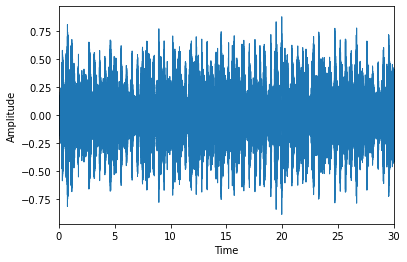

In [ ]:
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Frequency Domain (Fast Fourier Transform)

In [ ]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft) # indication of contribution of each frequency to the overall sound
frequency = np.linspace(0, sr, len(magnitude)) #gives a number of evenly spaced numbers in an interval. 
# Frequency interval is here 0 HZ and sample rate. Number of evenly paced values we want which is the length of magnitude


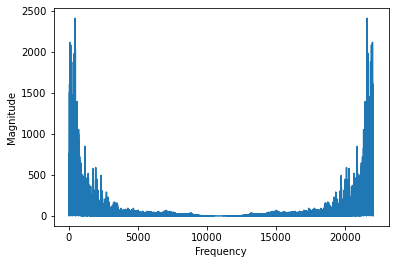

In [ ]:
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### Interpretation
The first half of this is what brings us the novelty, the second half is the same information with the first half. Let's handle it by dividing it by two. 

In [ ]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

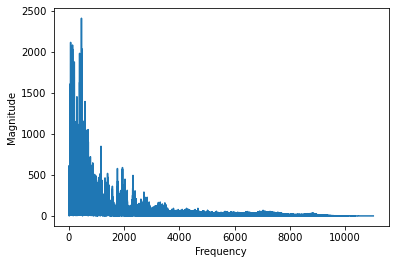

In [ ]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
#@title
#number of samples per fft  (number of samples, window we're considering for performing a single fft)
n_fft = 2048
#amount we're shifting each fourier transform to the right. When we doSTFT we slide an interval, 
#each interval we calculate a fft and hop_length will tell us how much we're shifting
hop_length = 512


In [ ]:
#@title
stft = librosa.core.stft(signal, hop_length = hop_length, n_fft = n_fft)
spectogram = np.abs(stft)

In [ ]:
#@title
log_spectogram = librosa.amplitude_to_db(spectogram)

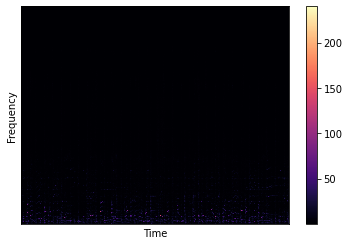

In [ ]:
#@title
librosa.display.specshow(spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

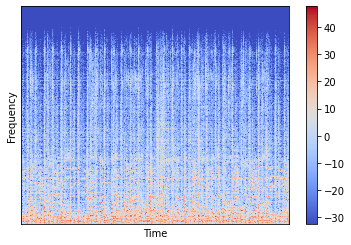

In [ ]:
#@title
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

### MFFCs (Mel Frequency Cepstral Coefficients)

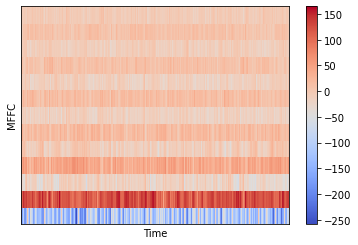

In [ ]:
MFFCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFFC")
plt.colorbar()
plt.show()

In [ ]:
# TESTING

# file_path = '/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres_original_copy/blues/blues.00000.wav'

# data = {
#         "mapping": [],
#         "mfcc": [],
#         "labels": []
#     }

# num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) # 22050 * 30 / 10  
# num_mfcc = 13
# expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/hop_length) # # (22050 * 30) / (10 * 512 )


# signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
# num_segments = 1

# # process segments extracting mfcc and storing data 
# for s in range(num_segments):
#     start_sample = num_samples_per_segment * s #s=0 -> 0
#     finish_sample = start_sample + num_samples_per_segment #s=0 -> num_samples_per_segment

#     mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

#     mfcc = mfcc.T

#     # store mfcc for segment if it has the expected length 
#     if len(mfcc) == expected_num_mfcc_vectors_per_segment:
#         data["mfcc"].append(mfcc.tolist())
#         data["labels"].append(0)
#         print("{}, segment:{}".format(file_path, s+1))
        

        
# JSON_PATH = "data3.json"
# with open(JSON_PATH, "w") as fp:
#         json.dump(data,fp, indent=4)


In [ ]:
if __name__ == "__main__":
    save_mfcc(TH_DATASET_PATH, JSON_PATH, num_segments=1)

NameError: ignored

In [ ]:
def plot_accuracy(history):
    fig, ax = plt.subplots()

    # create accuracy sublpot
    ax.plot(history.history["accuracy"], label="train accuracy")
    ax.plot(history.history["val_accuracy"], label="test accuracy")
    ax.set_ylabel("Accuracy")
    ax.legend(loc="lower right")
    ax.set_title("Accuracy eval")

    plt.show()



In [ ]:
def plot_loss(history):
    fig, ax = plt.subplots()
    
    # create error sublpot
    ax.plot(history.history["loss"], label="train error")
    ax.plot(history.history["val_loss"], label="test error")
    ax.set_ylabel("Error")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")
    ax.set_title("Error eval")

    plt.show()

# Music Genre Multi-classification with Neural Network 
The steps are as the followings: 
- Load the data 
- Split the data into train, validation and test sets 
- Building neural network 
- Compiling 
- Training 
- Testing

In [ ]:
print(JSON_PATH)

/mfcc_200_songs_15.json


### Load Data

In [ ]:
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)
    print(data)

inputs = np.array(data["mfcc"])
targets = np.array(data["labels"])

{'mapping': [], 'mfcc': [], 'labels': []}


### Splitting Data to train and test

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(inputs, targets, test_size=0.2)

### Building NN

In [ ]:
# inputs is 3D: index, intervals and MFCC values, therefore, inputs[1] - intervals , inputps[2] - values of MFCCs

model = keras.Sequential([
    keras.layers.Flatten(input_shape = (inputs.shape[1], inputs.shape[2])),
    
    #1st hidden layer 
#     keras.layers.Dense(512, activation = "relu",  name="layer1"), 
    
    #2nd hidden layer 
    keras.layers.Dense(256, activation = "relu",  name="layer2"), 
    
    #3nd hidden layer 
    keras.layers.Dense(64, activation = "relu",  name="layer3"), 
    
    #output layer 
    keras.layers.Dense(10, activation = "softmax",  name="outputlayer") # labels. (Softmax is for multiclasss, sigmoid for binary classification)
])


### Compiling 

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 layer2 (Dense)              (None, 256)               432896    
                                                                 
 layer3 (Dense)              (None, 64)                16448     
                                                                 
 outputlayer (Dense)         (None, 10)                650       
                                                                 
Total params: 449,994
Trainable params: 449,994
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title
print(len(model.layers)) 

4


### Train network

In [ ]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=150, 
          batch_size=32)

Epoch 1/150
250/250 [==============================] - 2s 6ms/step - loss: 0.1625 - accuracy: 0.9479 - val_loss: 2.4306 - val_accuracy: 0.6041
Epoch 2/150
250/250 [==============================] - 2s 6ms/step - loss: 0.0481 - accuracy: 0.9849 - val_loss: 2.4495 - val_accuracy: 0.6311
Epoch 3/150
250/250 [==============================] - 2s 6ms/step - loss: 0.0189 - accuracy: 0.9955 - val_loss: 2.4479 - val_accuracy: 0.6301
Epoch 4/150
250/250 [==============================] - 2s 7ms/step - loss: 0.0572 - accuracy: 0.9813 - val_loss: 2.5878 - val_accuracy: 0.6251
Epoch 5/150
250/250 [==============================] - 2s 6ms/step - loss: 0.1655 - accuracy: 0.9532 - val_loss: 3.2136 - val_accuracy: 0.5490
Epoch 6/150
250/250 [==============================] - 2s 6ms/step - loss: 0.3015 - accuracy: 0.9134 - val_loss: 2.7126 - val_accuracy: 0.6071
Epoch 7/150
250/250 [==============================] - 2s 6ms/step - loss: 0.1085 - accuracy: 0.9654 - val_loss: 2.5486 - val_accuracy: 0.6261

In [ ]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=50, 
          batch_size=32)

Epoch 1/50
250/250 [==============================] - 1s 4ms/step - loss: 8.6046 - accuracy: 0.3023 - val_loss: 2.5140 - val_accuracy: 0.2012
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 2.2080 - accuracy: 0.2146 - val_loss: 2.2395 - val_accuracy: 0.2262
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 2.0113 - accuracy: 0.2964 - val_loss: 2.1357 - val_accuracy: 0.2628
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 1.9261 - accuracy: 0.3259 - val_loss: 2.1343 - val_accuracy: 0.3073
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 1.8369 - accuracy: 0.3629 - val_loss: 2.0723 - val_accuracy: 0.3238
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 1.7660 - accuracy: 0.3837 - val_loss: 2.0994 - val_accuracy: 0.3664
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 1.7436 - accuracy: 0.3956 - val_loss: 2.0384 - val_accuracy: 0.3323
Epoch 

### Overfitting... 

### Plotting

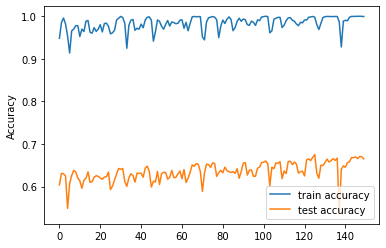

In [ ]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")    
plt.show()

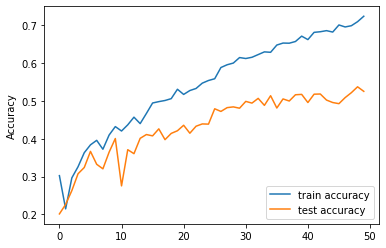

In [ ]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")    
plt.show()

# Convolutional Neural Network

In [ ]:
len(inputs)

10986

In [ ]:
inputs.shape

(10986, 130, 13)

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(inputs, targets, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

NameError: ignored

In [ ]:
print(X_train[0][0][0])

-100.62495422363281


In [ ]:

X_train.shape

(7690, 130, 13)

In [ ]:

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1) ##

In [ ]:
print(input_shape)

In [ ]:
model_cnn = keras.Sequential()

# st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [ ]:

history = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=60)

Epoch 1/60
219/219 [==============================] - 6s 25ms/step - loss: 2.4765 - accuracy: 0.2040 - val_loss: 1.8575 - val_accuracy: 0.3478
Epoch 2/60
219/219 [==============================] - 5s 24ms/step - loss: 1.8900 - accuracy: 0.3396 - val_loss: 1.5646 - val_accuracy: 0.4393
Epoch 3/60
219/219 [==============================] - 6s 25ms/step - loss: 1.6830 - accuracy: 0.3980 - val_loss: 1.4116 - val_accuracy: 0.5000
Epoch 4/60
219/219 [==============================] - 6s 25ms/step - loss: 1.5376 - accuracy: 0.4471 - val_loss: 1.3183 - val_accuracy: 0.5227
Epoch 5/60
219/219 [==============================] - 6s 28ms/step - loss: 1.4579 - accuracy: 0.4811 - val_loss: 1.2506 - val_accuracy: 0.5607
Epoch 6/60
219/219 [==============================] - 6s 25ms/step - loss: 1.3749 - accuracy: 0.5166 - val_loss: 1.1805 - val_accuracy: 0.5888
Epoch 7/60
219/219 [==============================] - 6s 26ms/step - loss: 1.3088 - accuracy: 0.5441 - val_loss: 1.1303 - val_accuracy: 0.5948

In [ ]:
# evaluate model on test set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

47/47 - 0s - loss: 0.7499 - accuracy: 0.7583 - 316ms/epoch - 7ms/step

Test accuracy: 0.7583444714546204


In [ ]:
len(X_test)

1498

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [ ]:
X_to_predict.shape

(130, 13, 1)

In [ ]:
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:

# perform prediction
# print(X_to_predict)
prediction = model_cnn.predict(X_to_predict)
# print(prediction)
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Target: {}, Predicted label: {}".format(y_to_predict, predicted_index))

Target: 5, Predicted label: [5]


### Plot accuracy/error for training and validation

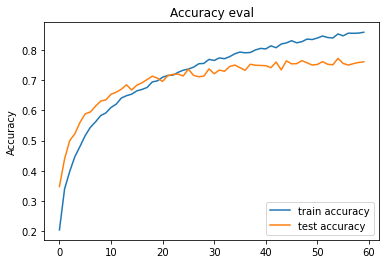

In [ ]:
plot_accuracy(history)

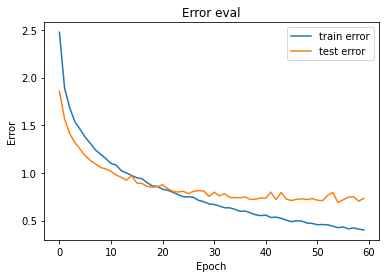

In [ ]:
#@title
plot_loss(history)

## Preparation of mugam data

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
new_songs_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original"
wav_songs_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres+mugam/mugam"

In [ ]:
# Find those song files
onlyfiles = [f for f in listdir(new_songs_path) if isfile(join(new_songs_path, f))]

In [ ]:
print(onlyfiles)

['10.MAHUR.mp3', '2.HEYRATI.mp3', '14.DASHDI.mp3', '3.QATAR.mp3', '7.SHUSHTAR TASNIFI.mp3', '2.CAHARGAH.mp3', '3.TASNIF MENDE YOXDUR.mp3', '4.TASNIF SHUSHA.mp3', '2.RAHAB 2.mp3', '9.DURUN GEDAK.mp3', '4.HUMAYUN.mp3', '4.ARAQ-PANJIGAH.mp3', '3.MIRZA HUSEYN SEGAHI.mp3', '2.BAYATI-SHIRAZ 2.mp3', '11.SEGAH.mp3', '.DS_Store', '3.BAYATI-SHIRAZ 2.mp3', '7.ARAQ TASNIFI.mp3', '3.MANSURIYYA.mp3', '5.OSMANLI TASNIFI.mp3', '3.ARAQ.mp3', '1.BAYATI-SHIRAZ 3.mp3', '2.BAYATI.mp3', '2.CAHARGAH 2.mp3', '1.ZABUL-SEGAH.mp3', 'VILAYATI-DILKASH.mp3', '4.MANSURIYYA.mp3', '12.MAHUR-HINDI-2.mp3', '2.MIRZA HUSEYN SEGAHI 2.mp3', '9.MAHUR-HINDI.mp3', '1.BAYATI-SHIRAZ 2.mp3', '2.RAHAB.mp3', '7.BUDAQ SARI.mp3', '2.BAYATI-KURD.mp3', '11.BAYATI-SHIRAZ.mp3', '3.BAYATI-ACAM.mp3', '15.YERI, DAM USTA YERI.mp3', '5.MAYE-SHUR.mp3', '4.SEGAH.mp3', '1.SEGAH-ZABUL.mp3', '2.RAST 3.mp3', '13.ZAMINXARA.mp3', '1.CHOBAN-BAYATI.mp3', '4.TASNIF MENDEN OLDU.mp3', '3.SHUR TASNIFI 2.mp3', '2.RAST 2.mp3', '3.SHUSHTAR.mp3', '9.KEREMI.mp3

In [ ]:
numb = 0
audio_length = 30 * 1000 # in milliseconds, 30 seconds
for f in onlyfiles: 
    filename = os.fsdecode(f)
    if filename.endswith(".mp3"):
        xpath = os.path.join(new_songs_path,filename)
        print(xpath)
        new  = os.path.join(os.path.join(wav_songs_path),"mugam."+ str(numb).zfill(5) + ".wav" )
        audSeg = AudioSegment.from_mp3(xpath)
        audSeg = audSeg[0:audio_length]
        audSeg = audSeg.set_frame_rate(22050)
        audSeg.export(new, format="wav")
        numb = numb +  1

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/10.MAHUR.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/2.HEYRATI.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/14.DASHDI.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/3.QATAR.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/7.SHUSHTAR TASNIFI.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/2.CAHARGAH.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original/3.TASNIF MENDE YOXDUR.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classi

## Writing MFCC to json with genre mugam

In [ ]:
NEW_DATASET_PATH = "./Data/genres+mugam"
NEW_JSON_PATH = "new_data.json"
onesegment_NEW_JSON_PATH = "onesegment_new_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [ ]:
save_mfcc(NEW_DATASET_PATH, NEJSON_PATH, num_segments=10)

130

Processing pop
pop.00027.wav
./Data/genres+mugam/pop/pop.00027.wav, segment:1
./Data/genres+mugam/pop/pop.00027.wav, segment:2
./Data/genres+mugam/pop/pop.00027.wav, segment:3
./Data/genres+mugam/pop/pop.00027.wav, segment:4
./Data/genres+mugam/pop/pop.00027.wav, segment:5
./Data/genres+mugam/pop/pop.00027.wav, segment:6
./Data/genres+mugam/pop/pop.00027.wav, segment:7
./Data/genres+mugam/pop/pop.00027.wav, segment:8
./Data/genres+mugam/pop/pop.00027.wav, segment:9
./Data/genres+mugam/pop/pop.00027.wav, segment:10
pop.00033.wav
./Data/genres+mugam/pop/pop.00033.wav, segment:1
./Data/genres+mugam/pop/pop.00033.wav, segment:2
./Data/genres+mugam/pop/pop.00033.wav, segment:3
./Data/genres+mugam/pop/pop.00033.wav, segment:4
./Data/genres+mugam/pop/pop.00033.wav, segment:5
./Data/genres+mugam/pop/pop.00033.wav, segment:6
./Data/genres+mugam/pop/pop.00033.wav, segment:7
./Data/genres+mugam/pop/pop.00033.wav, segment:8
./Data/genres+mugam/pop/pop.00033.wav, segment:9
./Data/genres+mugam/

## CNN with Mugam data

In [ ]:
save_mfcc(DATASET_PATH, onesegment_NEW_JSON_PATH, num_segments=1)

1292

Processing pop
pop.00027.wav
./Data/genres_original/pop/pop.00027.wav, segment:1
pop.00033.wav
./Data/genres_original/pop/pop.00033.wav, segment:1
pop.00032.wav
./Data/genres_original/pop/pop.00032.wav, segment:1
pop.00026.wav
./Data/genres_original/pop/pop.00026.wav, segment:1
pop.00030.wav
./Data/genres_original/pop/pop.00030.wav, segment:1
pop.00024.wav
./Data/genres_original/pop/pop.00024.wav, segment:1
pop.00018.wav
./Data/genres_original/pop/pop.00018.wav, segment:1
pop.00019.wav
./Data/genres_original/pop/pop.00019.wav, segment:1
pop.00025.wav
./Data/genres_original/pop/pop.00025.wav, segment:1
pop.00031.wav
./Data/genres_original/pop/pop.00031.wav, segment:1
pop.00009.wav
./Data/genres_original/pop/pop.00009.wav, segment:1
pop.00035.wav
./Data/genres_original/pop/pop.00035.wav, segment:1
pop.00021.wav
./Data/genres_original/pop/pop.00021.wav, segment:1
pop.00020.wav
./Data/genres_original/pop/pop.00020.wav, segment:1
pop.00034.wav
./Data/genres_original/pop/pop.00034.wav,

In [ ]:
NEW_DATASET_PATH = "./Data/genres+mugam"
NEW_JSON_PATH = "new_data.json"

In [ ]:
with open(NEW_JSON_PATH, "r") as fp:
    new_data = json.load(fp)

In [ ]:
new_inputs = np.array(new_data["mfcc"])
new_targets = np.array(new_data["labels"])

In [ ]:
len(new_targets)

In [ ]:
new_inputs.shape

(10986, 130, 13)

In [ ]:
len(new_inputs)

10986

In [ ]:
new_X_train, new_X_test, new_y_train, new_y_test =  train_test_split(new_inputs, new_targets, test_size=0.3)
new_X_test, new_X_val, new_y_test, new_y_val = train_test_split(new_X_test, new_y_test, test_size=0.5)

In [ ]:
# add an axis to input sets
new_X_train = new_X_train[..., np.newaxis]
new_X_val = new_X_val[..., np.newaxis]
new_X_test = new_X_test[..., np.newaxis]

In [ ]:
new_input_shape = (new_X_train.shape[1], new_X_train.shape[2], 1) ##

In [ ]:
new_model_cnn_2 = keras.Sequential()

# st conv layer
new_model_cnn_2.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=new_input_shape))
new_model_cnn_2.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
new_model_cnn_2.add(keras.layers.BatchNormalization())

# 2nd conv layer
new_model_cnn_2.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
new_model_cnn_2.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
new_model_cnn_2.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
new_model_cnn_2.add(keras.layers.Flatten())
new_model_cnn_2.add(keras.layers.Dense(64, activation='relu'))
new_model_cnn_2.add(keras.layers.Dropout(0.3))

# output layer
new_model_cnn_2.add(keras.layers.Dense(11, activation='softmax'))

NameError: name 'new_input_shape' is not defined

In [ ]:
new_model_cnn = keras.Sequential()

# st conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=new_input_shape))
new_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
new_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
new_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
new_model_cnn.add(keras.layers.Flatten())
new_model_cnn.add(keras.layers.Dense(64, activation='relu'))
new_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
new_model_cnn.add(keras.layers.Dense(11, activation='softmax'))


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
new_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

new_model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 64, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 2, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
new_history = new_model_cnn.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=60)

Epoch 1/60
241/241 [==============================] - 7s 26ms/step - loss: 2.2213 - accuracy: 0.2823 - val_loss: 1.6576 - val_accuracy: 0.4205
Epoch 2/60
241/241 [==============================] - 6s 25ms/step - loss: 1.6887 - accuracy: 0.4098 - val_loss: 1.4138 - val_accuracy: 0.4812
Epoch 3/60
241/241 [==============================] - 6s 26ms/step - loss: 1.5106 - accuracy: 0.4707 - val_loss: 1.2683 - val_accuracy: 0.5309
Epoch 4/60
241/241 [==============================] - 6s 25ms/step - loss: 1.3867 - accuracy: 0.5055 - val_loss: 1.2025 - val_accuracy: 0.5546
Epoch 5/60
241/241 [==============================] - 6s 26ms/step - loss: 1.3051 - accuracy: 0.5372 - val_loss: 1.1467 - val_accuracy: 0.5837
Epoch 6/60
241/241 [==============================] - 6s 26ms/step - loss: 1.2472 - accuracy: 0.5562 - val_loss: 1.0900 - val_accuracy: 0.5989
Epoch 7/60
241/241 [==============================] - 7s 29ms/step - loss: 1.1976 - accuracy: 0.5722 - val_loss: 1.0554 - val_accuracy: 0.6123

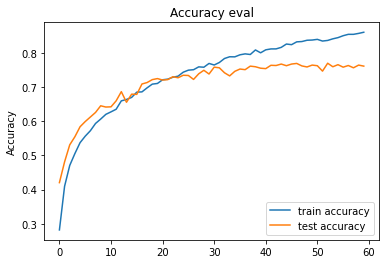

In [ ]:
plot_accuracy(new_history)

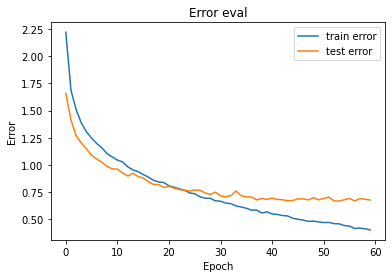

In [ ]:
plot_loss(new_history)

In [ ]:
# evaluate model on test set
new_test_loss, new_test_acc = new_model_cnn.evaluate(new_X_test, new_y_test, verbose=2)
print('\nTest accuracy:', new_test_acc)

52/52 - 0s - loss: 0.6661 - accuracy: 0.7834 - 298ms/epoch - 6ms/step

Test accuracy: 0.7833737730979919


In [ ]:
# pick a sample to predict from the test set
new_X_to_predict = new_X_test[100]
new_y_to_predict = new_y_test[100]

In [ ]:
new_X_to_predict.shape

(130, 13, 1)

In [ ]:
new_X_to_predict = new_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
# perform prediction
# print(X_to_predict)
new_prediction = new_model_cnn.predict(new_X_to_predict)
# print(prediction)
# get index with max value
new_predicted_index = np.argmax(new_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(new_y_to_predict, new_predicted_index))

Target: 10, Predicted label: [3]


## CNN with 1 segment size 

In [ ]:
onesegment_NEW_JSON_PATH = "onesegment_new_data.json"

In [ ]:
with open(onesegment_NEW_JSON_PATH, "r") as fp:
    seg1_new_data = json.load(fp) 

In [ ]:
seg1_inputs = np.array(seg1_new_data["mfcc"])
seg1_targets = np.array(seg1_new_data["labels"])

seg1_inputs.shape

(1098, 1292, 13)

In [ ]:
seg1_X_train, seg1_X_test, seg1_y_train, seg1_y_test =  train_test_split(seg1_inputs, seg1_targets, test_size=0.3)
seg1_X_test, seg1_X_val, seg1_y_test, seg1_y_val = train_test_split(seg1_X_test, seg1_y_test, test_size=0.5)

In [ ]:
seg1_X_train = seg1_X_train[..., np.newaxis]
seg1_X_val = seg1_X_val[..., np.newaxis]
seg1_X_test = seg1_X_test[..., np.newaxis]

In [ ]:
seg1_inputs_shape = (seg1_X_train.shape[1], seg1_X_train.shape[2], 1) ##

In [ ]:
seg1_model_cnn = keras.Sequential()

In [ ]:
# st conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=seg1_inputs_shape))
seg1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
seg1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
seg1_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
seg1_model_cnn.add(keras.layers.Flatten())
seg1_model_cnn.add(keras.layers.Dense(64, activation='relu'))
seg1_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
seg1_model_cnn.add(keras.layers.Dense(11, activation='softmax'))


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
seg1_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

seg1_model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1290, 11, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 645, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 645, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 643, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 322, 2, 32)       0         
 2D)                                                             
                                                      

In [ ]:
segone_history = seg1_model_cnn.fit(seg1_X_train, seg1_y_train, validation_data=(seg1_X_val, seg1_y_val), batch_size=32, epochs=60)

Epoch 1/60
24/24 [==============================] - 6s 221ms/step - loss: 2.7872 - accuracy: 0.1966 - val_loss: 4.1844 - val_accuracy: 0.1455
Epoch 2/60
24/24 [==============================] - 5s 211ms/step - loss: 1.9329 - accuracy: 0.3776 - val_loss: 3.4893 - val_accuracy: 0.1515
Epoch 3/60
24/24 [==============================] - 5s 214ms/step - loss: 1.5863 - accuracy: 0.4531 - val_loss: 2.9237 - val_accuracy: 0.2061
Epoch 4/60
24/24 [==============================] - 5s 211ms/step - loss: 1.3264 - accuracy: 0.5560 - val_loss: 2.5489 - val_accuracy: 0.2545
Epoch 5/60
24/24 [==============================] - 5s 211ms/step - loss: 1.1140 - accuracy: 0.6354 - val_loss: 2.1938 - val_accuracy: 0.3091
Epoch 6/60
24/24 [==============================] - 5s 211ms/step - loss: 0.9892 - accuracy: 0.6784 - val_loss: 1.9616 - val_accuracy: 0.3576
Epoch 7/60
24/24 [==============================] - 5s 213ms/step - loss: 0.8816 - accuracy: 0.6914 - val_loss: 1.8218 - val_accuracy: 0.3939
Epoch 

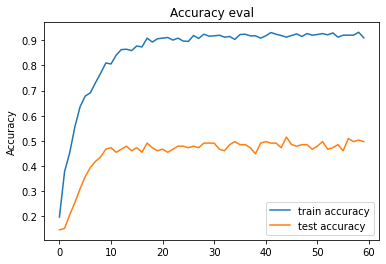

In [ ]:
plot_accuracy(segone_history)

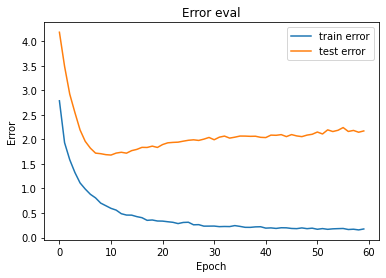

In [ ]:
plot_loss(segone_history)

In [ ]:
# evaluate model on test set
seg1_test_loss, seg1_test_acc = seg1_model_cnn.evaluate(seg1_X_test, seg1_y_test, verbose=2)
print('\nTest accuracy:', seg1_test_acc)

6/6 - 0s - loss: 2.0282 - accuracy: 0.4909 - 301ms/epoch - 50ms/step

Test accuracy: 0.4909090995788574


In [ ]:
# pick a sample to predict from the test set
seg1_X_to_predict = seg1_X_test[100]
seg1_y_to_predict = seg1_y_test[100]

In [ ]:
seg1_X_to_predict.shape

(1292, 13, 1)

In [ ]:
seg1_X_to_predict = seg1_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
# perform prediction
# print(X_to_predict)
seg1_prediction = seg1_model_cnn.predict(seg1_X_to_predict)
# print(prediction)
# get index with max value
seg1_predicted_index = np.argmax(seg1_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(seg1_y_to_predict, seg1_predicted_index))

Target: 4, Predicted label: [4]


## RNN-LSTM 

In [ ]:
lstm_model = keras.Sequential()

In [ ]:
smaller_lstm_model = keras.Sequential()

In [ ]:
lstm_input_shape = (new_X_train.shape[1], new_X_train.shape[2]) ##

In [ ]:
lstm_model.add(keras.layers.LSTM(64, input_shape=lstm_input_shape, return_sequences=True))
lstm_model.add(keras.layers.LSTM(64))

# dense layer
lstm_model.add(keras.layers.Dense(64, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.3))

# output layer
lstm_model.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
smaller_lstm_model.add(keras.layers.LSTM(32, input_shape=lstm_input_shape, return_sequences=True))
smaller_lstm_model.add(keras.layers.LSTM(32))

# dense layer
smaller_lstm_model.add(keras.layers.Dense(32, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.3))

# output layer
smaller_lstm_model.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 130, 64)           19968     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 11)                715       
                                                                 
Total params: 57,867
Trainable params: 57,867
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
smaller_lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

smaller_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 130, 32)           5888      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 11)                363       
                                                                 
Total params: 15,627
Trainable params: 15,627
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=60)

Epoch 1/60
241/241 [==============================] - 17s 63ms/step - loss: 2.2739 - accuracy: 0.2168 - val_loss: 2.0864 - val_accuracy: 0.2888
Epoch 2/60
241/241 [==============================] - 15s 62ms/step - loss: 1.8933 - accuracy: 0.3645 - val_loss: 1.7380 - val_accuracy: 0.4193
Epoch 3/60
241/241 [==============================] - 15s 61ms/step - loss: 1.6637 - accuracy: 0.4324 - val_loss: 1.5891 - val_accuracy: 0.4478
Epoch 4/60
241/241 [==============================] - 15s 61ms/step - loss: 1.5491 - accuracy: 0.4586 - val_loss: 1.5173 - val_accuracy: 0.4600
Epoch 5/60
241/241 [==============================] - 15s 61ms/step - loss: 1.4747 - accuracy: 0.4880 - val_loss: 1.4396 - val_accuracy: 0.5097
Epoch 6/60
241/241 [==============================] - 15s 62ms/step - loss: 1.4081 - accuracy: 0.5109 - val_loss: 1.4057 - val_accuracy: 0.5261
Epoch 7/60
241/241 [==============================] - 15s 61ms/step - loss: 1.3487 - accuracy: 0.5268 - val_loss: 1.3779 - val_accuracy:

In [ ]:
v2_lstm_history = lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=150)

Epoch 1/150
241/241 [==============================] - 14s 60ms/step - loss: 0.6031 - accuracy: 0.8101 - val_loss: 1.0260 - val_accuracy: 0.6845
Epoch 2/150
241/241 [==============================] - 15s 60ms/step - loss: 0.6007 - accuracy: 0.8092 - val_loss: 1.0459 - val_accuracy: 0.6851
Epoch 3/150
241/241 [==============================] - 15s 61ms/step - loss: 0.5754 - accuracy: 0.8192 - val_loss: 1.0217 - val_accuracy: 0.6948
Epoch 4/150
241/241 [==============================] - 15s 61ms/step - loss: 0.5753 - accuracy: 0.8199 - val_loss: 1.0443 - val_accuracy: 0.6814
Epoch 5/150
241/241 [==============================] - 15s 62ms/step - loss: 0.5687 - accuracy: 0.8216 - val_loss: 1.0435 - val_accuracy: 0.6778
Epoch 6/150
241/241 [==============================] - 15s 62ms/step - loss: 0.5581 - accuracy: 0.8268 - val_loss: 1.0548 - val_accuracy: 0.6863
Epoch 7/150
241/241 [==============================] - 15s 61ms/step - loss: 0.5571 - accuracy: 0.8213 - val_loss: 1.0481 - val_ac

In [ ]:
smaller_lstm_history = smaller_lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=75)

Epoch 1/75
241/241 [==============================] - 16s 56ms/step - loss: 2.3403 - accuracy: 0.2038 - val_loss: 2.2802 - val_accuracy: 0.2458
Epoch 2/75
241/241 [==============================] - 13s 53ms/step - loss: 2.1503 - accuracy: 0.2757 - val_loss: 2.0523 - val_accuracy: 0.2992
Epoch 3/75
241/241 [==============================] - 13s 54ms/step - loss: 1.9249 - accuracy: 0.3446 - val_loss: 1.8831 - val_accuracy: 0.3550
Epoch 4/75
241/241 [==============================] - 13s 54ms/step - loss: 1.7802 - accuracy: 0.3852 - val_loss: 1.7600 - val_accuracy: 0.3956
Epoch 5/75
241/241 [==============================] - 13s 54ms/step - loss: 1.6734 - accuracy: 0.4205 - val_loss: 1.6791 - val_accuracy: 0.4053
Epoch 6/75
241/241 [==============================] - 13s 56ms/step - loss: 1.6022 - accuracy: 0.4333 - val_loss: 1.6136 - val_accuracy: 0.4333
Epoch 7/75
241/241 [==============================] - 13s 54ms/step - loss: 1.5462 - accuracy: 0.4467 - val_loss: 1.5631 - val_accuracy:

In [ ]:
smaller_lstm_history = smaller_lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=75)

Epoch 1/75
241/241 [==============================] - 13s 53ms/step - loss: 0.9958 - accuracy: 0.6450 - val_loss: 1.2649 - val_accuracy: 0.5528
Epoch 2/75
241/241 [==============================] - 13s 53ms/step - loss: 0.9873 - accuracy: 0.6503 - val_loss: 1.2770 - val_accuracy: 0.5637
Epoch 3/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9950 - accuracy: 0.6454 - val_loss: 1.2497 - val_accuracy: 0.5674
Epoch 4/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9776 - accuracy: 0.6528 - val_loss: 1.2553 - val_accuracy: 0.5637
Epoch 5/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9739 - accuracy: 0.6527 - val_loss: 1.2544 - val_accuracy: 0.5643
Epoch 6/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9731 - accuracy: 0.6523 - val_loss: 1.2488 - val_accuracy: 0.5765
Epoch 7/75
241/241 [==============================] - 13s 54ms/step - loss: 0.9708 - accuracy: 0.6547 - val_loss: 1.2516 - val_accuracy:

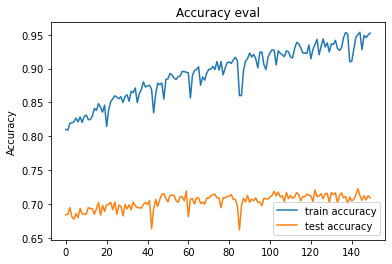

In [ ]:
plot_accuracy(v2_lstm_history)

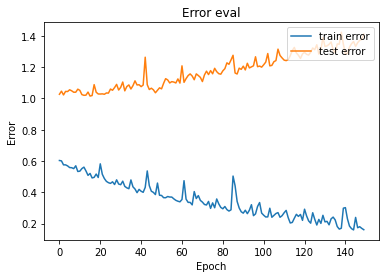

In [ ]:
plot_loss(v2_lstm_history)

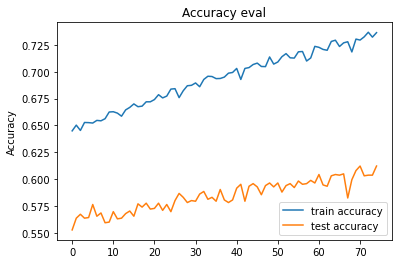

In [ ]:
plot_accuracy(smaller_lstm_history)

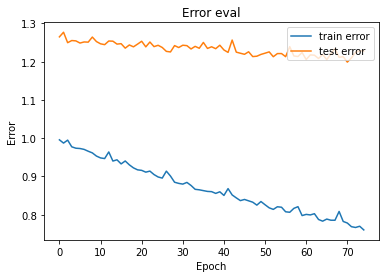

In [ ]:
plot_loss(smaller_lstm_history)

In [ ]:
# evaluate model on test set
lstm_test_loss, lstm_test_acc = lstm_model_cnn.evaluate(new_X_test, new_y_test, verbose=2)
print('\nTest accuracy:', lstm_test_acc)

In [ ]:
# pick a sample to predict from the test set
new_X_to_predict = new_X_test[100]
new_y_to_predict = new_y_test[100]

In [ ]:
new_X_to_predict.shape

In [ ]:
new_X_to_predict = new_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
# perform prediction
# print(X_to_predict)
new_prediction = lstm_model_cnn.predict(new_X_to_predict)
# print(prediction)
# get index with max value
new_predicted_index = np.argmax(new_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(new_y_to_predict, new_predicted_index))

NameError: name 'lstm_model_cnn' is not defined

## Extracting new  music/songs

## Classical

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_classic = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical"
write_path_classic = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/classical"

In [ ]:
write_as_wav(read_path_classic, write_path_classic, "classical.")

NameError: ignored

## Rock 

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_rock = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock"
write_path_rock = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/rock"

In [ ]:
write_as_wav(read_path_rock, write_path_rock, "rock.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/013. Shinedown - Simple Man.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/060. The Smashing Pumpkins - 1979 (Remastered 2012).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/034. Theory of a Deadman - Rx (Medicate).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/015. Red Hot Chili Peppers - Under the Bridge.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/053. Godsmack - Under Your Scars.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock/093. Stone Sour - Through Glass.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-

## Blues

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_blues = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues"
write_path_blues = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/blues"

In [ ]:
write_as_wav(read_path_blues, write_path_blues, "blues.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Marvin Gaye - Little Darling I Need You.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Martha Reeves & The Vandellas - (Love Is Like A) Heat Wave.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/The Four Tops - I Can't Help Myself (Sugar Pie, Honey Bunch).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Steve Winwood (Spencer Davis Group) - Gimme Some Lovin'.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Aretha Franklin - Chain Of Fools.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues/Otis Redding - Sittin' On The Dock Of The Bay.m

## Reggae

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_reggae = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae"
write_path_reggae = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/reggae"

In [ ]:
write_as_wav(read_path_reggae, write_path_reggae, "reggae.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/32. Wear You To The Ball - U-Roy & The Paragons.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/72. 1865 (96 Degrees In The Shade) - Third World.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/78. Feel Like Jumping - Marcia Griffiths.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/97. Electric Boogie - Marcia Griffiths.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/40. Natty Rebel - U-Roy.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae/57. I'm Still In Love With You - Alton Ellis.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA

## Country

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_country = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country"
write_path_country = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/country"

In [ ]:
#@title
write_as_wav(read_path_country, write_path_country, "country.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Jolene.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/I'll Fly Away.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/I've Got A Tiger By The Tail.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/500 Miles Away from Home.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Man in Black.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Mountain Dew.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country/Golden Ring.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fal

## Disco

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_disco = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco"
write_path_disco = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/disco"

In [ ]:
#@title
write_as_wav(read_path_disco, write_path_disco, "disco.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Good Times.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Spank - 12   Version.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/TSOP (The Sound of Philadelphia) - Extended Version.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/You're the One for Me.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Honey Bee - Extended Version.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/More, More, More.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco/Hot Stuff.mp3
/Users/ilyas

## Hiphop

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_hiphop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop"
write_path_hiphop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/hiphop"

In [ ]:
#@title
write_as_wav(read_path_hiphop, write_path_hiphop, "hiphop.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/098 - G Unit - Rider Pt. 2      (™ www.thisis50.com G Unit).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/056 - Jazmine Sullivan - Need U Bad     (™ J RMG).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/018 - V.I.C. - Get Silly      (™ Young Mogul Warner Bros.).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/097 - Colby O'Donis ft.  Akon - What You Got     (™ KonLive Geffen).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/033 - Shawty Lo - Foolish   (™  D4L Asylum).MP3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop/026 - Mar

## Jazz

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_jazz = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz"
write_path_jazz = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/jazz"

In [ ]:
#@title
write_as_wav(read_path_jazz, write_path_jazz, "jazz.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/096. The Brecker Brothers - Sneakin' Up Behind You.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/041. Courtney Pine - Butterfly.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/089. Pharoah Sanders - Astral Traveling.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/079. Pat Metheny - All the Things You Are.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/078. Bud Powell - Bouncin' With Bud.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz/074. Paco de Lucía - Beyond The Mirage.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasK

## Pop

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_pop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop"
write_path_pop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/pop"   

In [ ]:
#@title
write_as_wav(read_path_pop, write_path_pop, "pop.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/094 - Blink 182 - All The Small Things.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/076 - Radiohead - Creep.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/082 - Michael Jackson - Rock With You.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/055 - Nsync - Bye Bye Bye.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/057 - The Go-Gos - Our Lips Are Sealed.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop/090 - Brandy & Monica - The Boy Is Mine.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_

## Metal

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_metal = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal"
write_path_metal = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/metal"

In [ ]:
write_as_wav(read_path_metal, write_path_metal, "metal.")

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/027. Judas Priest - Living After Midnight.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/095. Dream Theater - Metropolis - Part I_ _The Miracle and the Sleeper_.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/091. Lamb of God - Redneck.mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/062. Iron Maiden - Fear of the Dark (2015 Remaster).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/051. Black Sabbath - Children of the Grave (2014 Remaster).mp3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal/003. Iron Maiden - Hallowed Be Thy Name (199

In [ ]:
TH_DATASET_PATH = "./Updated_data_09.03.2022"
TH_NEW_JSON_PATH = "/content/drive/MyDrive/Music_Genre_Classification/th_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [ ]:
save_mfcc(TH_DATASET_PATH, TH_NEW_JSON_PATH, num_segments=10)

NameError: ignored

## CNN with 200 new data

In [ ]:
conv1d_data["mfcc"]

[]

In [ ]:
th_inputs.shape

(31446, 87, 13)

CNN with old data

In [ ]:
th_targets.shape

(31446,)

In [ ]:
|th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(th_inputs, th_targets, test_size=0.2)
# th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

(25156, 87, 13)

In [ ]:
# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
# th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]

In [ ]:
th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

(87, 13, 1)


In [ ]:
th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 85, 11, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 43, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 4, 32)         9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 2, 32)        0         
 2D)                                                             
                                                      

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=60)

Epoch 1/60
787/787 [==============================] - 16s 8ms/step - loss: 2.2364 - accuracy: 0.2577 - val_loss: 1.7663 - val_accuracy: 0.3777
Epoch 2/60
787/787 [==============================] - 5s 7ms/step - loss: 1.8234 - accuracy: 0.3710 - val_loss: 1.5668 - val_accuracy: 0.4569
Epoch 3/60
787/787 [==============================] - 6s 7ms/step - loss: 1.6800 - accuracy: 0.4194 - val_loss: 1.4604 - val_accuracy: 0.5006
Epoch 4/60
787/787 [==============================] - 7s 8ms/step - loss: 1.5862 - accuracy: 0.4516 - val_loss: 1.3912 - val_accuracy: 0.5234
Epoch 5/60
787/787 [==============================] - 6s 8ms/step - loss: 1.5232 - accuracy: 0.4741 - val_loss: 1.3416 - val_accuracy: 0.5391
Epoch 6/60
787/787 [==============================] - 6s 7ms/step - loss: 1.4745 - accuracy: 0.4922 - val_loss: 1.3019 - val_accuracy: 0.5537
Epoch 7/60
787/787 [==============================] - 5s 7ms/step - loss: 1.4345 - accuracy: 0.5062 - val_loss: 1.2725 - val_accuracy: 0.5704
Epoch

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=30)

Epoch 1/30
787/787 [==============================] - 8s 11ms/step - loss: 0.8483 - accuracy: 0.7112 - val_loss: 0.9944 - val_accuracy: 0.6736
Epoch 2/30
787/787 [==============================] - 6s 7ms/step - loss: 0.8453 - accuracy: 0.7082 - val_loss: 0.9352 - val_accuracy: 0.6852
Epoch 3/30
787/787 [==============================] - 6s 7ms/step - loss: 0.8421 - accuracy: 0.7079 - val_loss: 0.9485 - val_accuracy: 0.6706
Epoch 4/30
787/787 [==============================] - 6s 7ms/step - loss: 0.8338 - accuracy: 0.7099 - val_loss: 0.9374 - val_accuracy: 0.6782
Epoch 5/30
787/787 [==============================] - 6s 7ms/step - loss: 0.8265 - accuracy: 0.7126 - val_loss: 0.9351 - val_accuracy: 0.6819
Epoch 6/30
787/787 [==============================] - 6s 7ms/step - loss: 0.8305 - accuracy: 0.7110 - val_loss: 0.9342 - val_accuracy: 0.6857
Epoch 7/30
787/787 [==============================] - 6s 7ms/step - loss: 0.8162 - accuracy: 0.7167 - val_loss: 0.9616 - val_accuracy: 0.6754
Epoch

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=30)

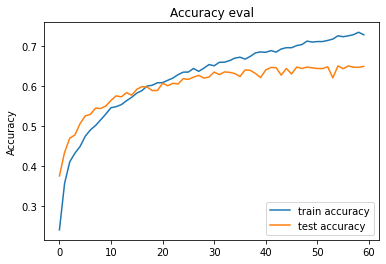

In [ ]:
plot_accuracy(th_history)

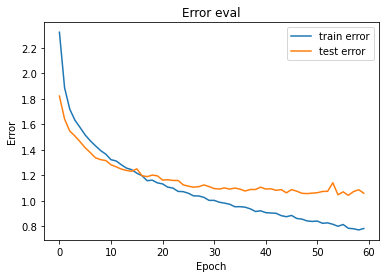

In [ ]:
plot_loss(th_history)

## Continuation

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

Epoch 1/60
459/459 [==============================] - 11s 24ms/step - loss: 0.7692 - accuracy: 0.7335 - val_loss: 1.0773 - val_accuracy: 0.6483
Epoch 2/60
459/459 [==============================] - 11s 25ms/step - loss: 0.7615 - accuracy: 0.7345 - val_loss: 1.0529 - val_accuracy: 0.6521
Epoch 3/60
459/459 [==============================] - 11s 25ms/step - loss: 0.7590 - accuracy: 0.7341 - val_loss: 1.0540 - val_accuracy: 0.6512
Epoch 4/60
459/459 [==============================] - 13s 27ms/step - loss: 0.7442 - accuracy: 0.7392 - val_loss: 1.0454 - val_accuracy: 0.6464
Epoch 5/60
459/459 [==============================] - 15s 33ms/step - loss: 0.7398 - accuracy: 0.7428 - val_loss: 1.0686 - val_accuracy: 0.6502
Epoch 6/60
459/459 [==============================] - 12s 27ms/step - loss: 0.7378 - accuracy: 0.7439 - val_loss: 1.0789 - val_accuracy: 0.6496
Epoch 7/60
459/459 [==============================] - 13s 28ms/step - loss: 0.7410 - accuracy: 0.7377 - val_loss: 1.0831 - val_accuracy:

## RNN-LSTM

In [ ]:
th_lstm_model = keras.Sequential()

In [ ]:
th_input_shape = (conv1d_X_train.shape[1], conv1d_X_train.shape[2]) ##

In [ ]:
th_lstm_model.add(keras.layers.LSTM(64, input_shape=th_input_shape, return_sequences=True))
th_lstm_model.add(keras.layers.LSTM(64))

# dense layer
th_lstm_model.add(keras.layers.Dense(64, activation='relu'))
th_lstm_model.add(keras.layers.Dropout(0.3))

# output layer
th_lstm_model.add(keras.layers.Dense(11, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.01)
th_lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 87, 64)            19968     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 11)                715       
                                                                 
Total params: 57,867
Trainable params: 57,867
Non-trainable params: 0
_________________________________________________________________


In [ ]:
th_lstm_history = th_lstm_model.fit(conv1d_X_train, conv1d_y_train, validation_data=(conv1d_X_val, conv1d_y_val), batch_size=32, epochs=60)

Epoch 1/60
688/688 [==============================] - 33s 43ms/step - loss: 1.8694 - accuracy: 0.3396 - val_loss: 1.6860 - val_accuracy: 0.4066
Epoch 2/60
688/688 [==============================] - 29s 42ms/step - loss: 1.6606 - accuracy: 0.4191 - val_loss: 1.5912 - val_accuracy: 0.4446
Epoch 3/60
688/688 [==============================] - 29s 42ms/step - loss: 1.5523 - accuracy: 0.4591 - val_loss: 1.5657 - val_accuracy: 0.4484
Epoch 4/60
688/688 [==============================] - 29s 42ms/step - loss: 1.5072 - accuracy: 0.4725 - val_loss: 1.4691 - val_accuracy: 0.4764
Epoch 5/60
688/688 [==============================] - 29s 42ms/step - loss: 1.4459 - accuracy: 0.4928 - val_loss: 1.4200 - val_accuracy: 0.5041
Epoch 6/60
688/688 [==============================] - 29s 42ms/step - loss: 1.4008 - accuracy: 0.5065 - val_loss: 1.4232 - val_accuracy: 0.5007
Epoch 7/60
688/688 [==============================] - 29s 42ms/step - loss: 1.3799 - accuracy: 0.5199 - val_loss: 1.3930 - val_accuracy:

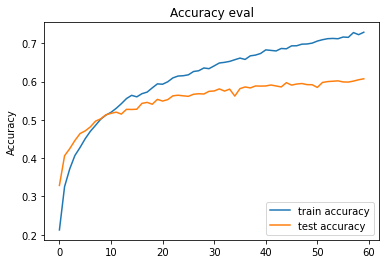

In [ ]:
plot_accuracy(th_lstm_history)

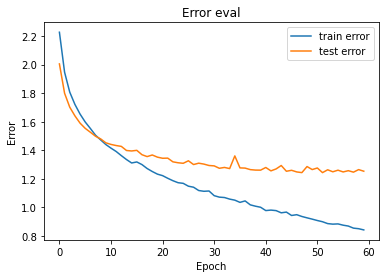

In [ ]:
plot_loss(th_lstm_history)

## New CNN with one dimensional convolutional layer.

In [ ]:
from tensorflow.keras.utils import to_categorical
import json

In [ ]:
'''data_dir = "/content/drive/MyDrive/Data's/Songs classifier/mfcc_200_songs_15.json"

with open(data_dir, "r") as fp:
    conv1d_data = json.load(fp)'''

In [ ]:
with open(TH_NEW_JSON_PATH, "r") as fp:
    conv1d_data = json.load(fp)

In [ ]:
conv1d_inputs = np.array(next_inputs["mfcc"])
conv1d_targets = np.array(next_inputs["labels"])

IndexError: ignored

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.4,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
#conv1d_X_train = conv1d_X_train[..., np.newaxis]
#conv1d_X_val = conv1d_X_val[..., np.newaxis]
#conv1d_X_test = conv1d_X_test[..., np.newaxis]

conv1d_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(conv1d_input_shape)

(87, 13, 1)


In [ ]:
th_y_train = to_categorical(th_y_train, 11)
th_y_val = to_categorical(th_y_val, 11)
th_y_test = to_categorical(th_y_test, 11)

In [ ]:
DROPOUT_RATE = 0.
CONV_DROPOUT_RATE = 0.2

In [ ]:
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input


In [ ]:
conv1d_input_shape

(87, 13, 1)

In [ ]:
# Create conv1d_model
conv1d_model =  keras.Sequential()

# First block
conv1d_model.add(Conv1D(filters=16,
                 kernel_size=3,
                 input_shape=(87,13),
                 activation='relu',
                 padding='same'))

conv1d_model.add(Conv1D(filters=16,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same'))
conv1d_model.add(keras.layers.Dropout(CONV_DROPOUT_RATE))

# Second block
conv1d_model.add(Conv1D(filters=32,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(Conv1D(filters=32,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(keras.layers.MaxPooling1D(pool_size=2,   strides=1, padding='same'))
conv1d_model.add(keras.layers.Dropout(CONV_DROPOUT_RATE))

# Third block
conv1d_model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(keras.layers.MaxPooling1D(pool_size=2,   strides=1, padding='same'))
conv1d_model.add(keras.layers.Dropout(CONV_DROPOUT_RATE))


# Fully connected layers
conv1d_model.add(Flatten())
conv1d_model.add(Dense(512, activation='relu'))
conv1d_model.add(Dense(512, activation='relu'))
conv1d_model.add(keras.layers.Dropout(CONV_DROPOUT_RATE))
# Output
conv1d_model.add(Dense(11, activation='softmax'),)

In [ ]:
conv1d_model.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      metrics=["accuracy"])

In [ ]:
conv1d_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 87, 16)            640       
                                                                 
 conv1d_29 (Conv1D)          (None, 87, 16)            784       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 87, 16)           0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 87, 16)            0         
                                                                 
 conv1d_30 (Conv1D)          (None, 87, 32)            1568      
                                                                 
 conv1d_31 (Conv1D)          (None, 87, 32)            3104      
                                                      

In [ ]:
conv1d_history = conv1d_model.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=100)

Epoch 1/100
574/574 [==============================] - 15s 7ms/step - loss: 2.8447 - accuracy: 0.1689 - val_loss: 2.0617 - val_accuracy: 0.2602
Epoch 2/100
574/574 [==============================] - 3s 6ms/step - loss: 1.9927 - accuracy: 0.2853 - val_loss: 1.9105 - val_accuracy: 0.3120
Epoch 3/100
574/574 [==============================] - 3s 6ms/step - loss: 1.8499 - accuracy: 0.3354 - val_loss: 1.8262 - val_accuracy: 0.3586
Epoch 4/100
574/574 [==============================] - 3s 6ms/step - loss: 1.7706 - accuracy: 0.3653 - val_loss: 1.8030 - val_accuracy: 0.3616
Epoch 5/100
574/574 [==============================] - 3s 6ms/step - loss: 1.7046 - accuracy: 0.3884 - val_loss: 1.6768 - val_accuracy: 0.4074
Epoch 6/100
574/574 [==============================] - 3s 6ms/step - loss: 1.6383 - accuracy: 0.4114 - val_loss: 1.6330 - val_accuracy: 0.4240
Epoch 7/100
574/574 [==============================] - 3s 6ms/step - loss: 1.5847 - accuracy: 0.4291 - val_loss: 1.5646 - val_accuracy: 0.457

KeyboardInterrupt: ignored

In [ ]:
conv1d_history = conv1d_model.fit(x = conv1d_X_train,
                                  y = conv1d_y_train,
                                  batch_size = 32,
                                  epochs = 5,
                                  validation_data = (conv1d_X_val, conv1d_y_val),
                                  steps_per_epoch = len(conv1d_X_train)//32,
                                  validation_steps = len(conv1d_X_val)//32)

Epoch 1/5
458/458 [==============================] - 34s 72ms/step - loss: 3.9241 - accuracy: 0.2902 - val_loss: 1.7281 - val_accuracy: 0.3996
Epoch 2/5
458/458 [==============================] - 32s 71ms/step - loss: 1.6217 - accuracy: 0.4307 - val_loss: 1.5987 - val_accuracy: 0.4416
Epoch 3/5
458/458 [==============================] - 32s 71ms/step - loss: 1.4604 - accuracy: 0.4880 - val_loss: 1.5828 - val_accuracy: 0.4426
Epoch 4/5
458/458 [==============================] - 32s 71ms/step - loss: 1.3345 - accuracy: 0.5366 - val_loss: 1.5256 - val_accuracy: 0.4633
Epoch 5/5
458/458 [==============================] - 32s 71ms/step - loss: 1.2094 - accuracy: 0.5826 - val_loss: 1.4290 - val_accuracy: 0.5003


Another model: 

In [ ]:
stride1_model_cnn = keras.Sequential()

# st conv layer
stride1_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape= next_inputs_shape))
stride1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'))
stride1_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
stride1_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
stride1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'))
stride1_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
stride1_model_cnn.add(keras.layers.Conv2D(16, (2, 2), activation='relu'))
stride1_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
stride1_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
stride1_model_cnn.add(keras.layers.Flatten())
stride1_model_cnn.add(keras.layers.Dense(32, activation='relu'))
stride1_model_cnn.add(keras.layers.Dropout(0.2))

# output layer
stride1_model_cnn.add(keras.layers.Dense(11, activation='softmax'))


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0005)
stride1_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

stride1_model_cnn.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 11, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 11, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 85, 11, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 9, 16)         2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 83, 9, 16)        0         
 2D)                                                             
                                                      

In [ ]:
stride1_history = stride1_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=80)

Epoch 1/80
765/765 [==============================] - 9s 12ms/step - loss: 2.0794 - accuracy: 0.2932 - val_loss: 1.7872 - val_accuracy: 0.4105
Epoch 2/80
765/765 [==============================] - 6s 8ms/step - loss: 1.7920 - accuracy: 0.3790 - val_loss: 1.5771 - val_accuracy: 0.4724
Epoch 3/80
765/765 [==============================] - 6s 8ms/step - loss: 1.6845 - accuracy: 0.4075 - val_loss: 1.5123 - val_accuracy: 0.4688
Epoch 4/80
765/765 [==============================] - 7s 9ms/step - loss: 1.6086 - accuracy: 0.4314 - val_loss: 1.4924 - val_accuracy: 0.4923
Epoch 5/80
765/765 [==============================] - 6s 8ms/step - loss: 1.5503 - accuracy: 0.4539 - val_loss: 1.4616 - val_accuracy: 0.4989
Epoch 6/80
765/765 [==============================] - 6s 8ms/step - loss: 1.5061 - accuracy: 0.4692 - val_loss: 1.3831 - val_accuracy: 0.5155
Epoch 7/80
765/765 [==============================] - 7s 9ms/step - loss: 1.4494 - accuracy: 0.4833 - val_loss: 1.3774 - val_accuracy: 0.5237
Epoch

In [ ]:
stride_2_history = stide1_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=90)

NameError: ignored

## CNN with new data

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.2,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape


In [ ]:
# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]

In [ ]:
next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)


In [ ]:
th_model_cnn_new_data = keras.Sequential()

# st conv layer
th_model_cnn_new_data.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=next_inputs_shape))
th_model_cnn_new_data.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn_new_data.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn_new_data.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn_new_data.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn_new_data.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn_new_data.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn_new_data.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
th_model_cnn_new_data.add(keras.layers.Flatten())
th_model_cnn_new_data.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn_new_data.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn_new_data.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
# compile model
optimiser = keras.optimizers.Adam()
th_model_cnn_new_data.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data.summary()

In [ ]:
th_history_new_data = th_model_cnn_new_data.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=90)


Epoch 1/90
765/765 [==============================] - 7s 9ms/step - loss: 2.1977 - accuracy: 0.2622 - val_loss: 1.7227 - val_accuracy: 0.4112
Epoch 2/90
765/765 [==============================] - 5s 6ms/step - loss: 1.7901 - accuracy: 0.3879 - val_loss: 1.5550 - val_accuracy: 0.4599
Epoch 3/90
765/765 [==============================] - 5s 7ms/step - loss: 1.6524 - accuracy: 0.4317 - val_loss: 1.4860 - val_accuracy: 0.4936
Epoch 4/90
765/765 [==============================] - 5s 7ms/step - loss: 1.5640 - accuracy: 0.4572 - val_loss: 1.4059 - val_accuracy: 0.5155
Epoch 5/90
765/765 [==============================] - 5s 7ms/step - loss: 1.4980 - accuracy: 0.4841 - val_loss: 1.3593 - val_accuracy: 0.5391
Epoch 6/90
765/765 [==============================] - 5s 7ms/step - loss: 1.4500 - accuracy: 0.5024 - val_loss: 1.3126 - val_accuracy: 0.5509
Epoch 7/90
765/765 [==============================] - 5s 7ms/step - loss: 1.4096 - accuracy: 0.5178 - val_loss: 1.2867 - val_accuracy: 0.5633
Epoch 

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn_new_data_2.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 85, 11, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 43, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 41, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 2, 32)        0         
 2D)                                                             
                                                      

In [ ]:
th_history_new_data_2 = th_model_cnn_new_data_2.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=90)

Epoch 1/90
765/765 [==============================] - 9s 9ms/step - loss: 1.7238 - accuracy: 0.4113 - val_loss: 1.3879 - val_accuracy: 0.5254
Epoch 2/90
765/765 [==============================] - 5s 7ms/step - loss: 1.3986 - accuracy: 0.5200 - val_loss: 1.2589 - val_accuracy: 0.5698
Epoch 3/90
765/765 [==============================] - 5s 7ms/step - loss: 1.2795 - accuracy: 0.5611 - val_loss: 1.2061 - val_accuracy: 0.5875
Epoch 4/90
765/765 [==============================] - 5s 7ms/step - loss: 1.2115 - accuracy: 0.5845 - val_loss: 1.1067 - val_accuracy: 0.6179
Epoch 5/90
765/765 [==============================] - 5s 6ms/step - loss: 1.1511 - accuracy: 0.6007 - val_loss: 1.0933 - val_accuracy: 0.6300
Epoch 6/90
765/765 [==============================] - 5s 7ms/step - loss: 1.1022 - accuracy: 0.6201 - val_loss: 1.0665 - val_accuracy: 0.6294
Epoch 7/90
765/765 [==============================] - 5s 7ms/step - loss: 1.0738 - accuracy: 0.6291 - val_loss: 1.1218 - val_accuracy: 0.6117
Epoch 

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.4,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

th_model_cnn_new_data_3 = keras.Sequential()

# st conv layer
th_model_cnn_new_data_3.add(keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape=next_inputs_shape))
th_model_cnn_new_data_3.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1) , padding='same'))
th_model_cnn_new_data_3.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn_new_data_3.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn_new_data_3.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn_new_data_3.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn_new_data_3.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
th_model_cnn_new_data_3.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_3.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_3.add(keras.layers.Dropout(0.3))

th_model_cnn_new_data_3.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
th_model_cnn_new_data_3.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_3.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_3.add(keras.layers.Dropout(0.3))

# flatten output and feed it into dense layer
th_model_cnn_new_data_3.add(keras.layers.Flatten())
th_model_cnn_new_data_3.add(keras.layers.Dense(256, activation='relu'))
th_model_cnn_new_data_3.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn_new_data_3.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn_new_data_3.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data_3.summary()

th_history_new_data = th_model_cnn_new_data_3.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)



(87, 13, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 86, 12, 16)        80        
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 86, 12, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_19 (Bat  (None, 86, 12, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 84, 10, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 42, 5, 32)        0         
 g2D)                                                            
                                         

learning rate = 0.0001, 60/20/20 
32, 32, 64, 64 
Epoch 90/90
574/574 [==============================] - 5s 9ms/step - loss: 0.5004 - accuracy: 0.8214 - val_loss: 1.2032 - val_accuracy: 0.6754

Epoch 60/60 ( her layer de 0.3 dropout, learning rate = 0.001, 60/20/20)
32, 32, 64, 64
574/574 [==============================] - 5s 8ms/step - loss: 1.0538 - 
accuracy: 0.6317 - val_loss: 0.9058 - val_accuracy: 0.6795
574/574 [==============================] - 5s 9ms/step - loss: 1.0277 - accuracy: 0.6436 - val_loss: 0.8922 - val_accuracy: 0.6909
Epoch 89/90
574/574 [==============================] - 5s 10ms/step - loss: 1.0019 - accuracy: 0.6514 - val_loss: 0.8376 - val_accuracy: 0.7110


32,32,64, 128  (64,128 de 0.3 dropout) 
learning rate = 0.001 
Epoch 150/150
574/574 [==============================] - 6s 10ms/step - loss: 0.4166 - accuracy: 0.8489 - val_loss: 0.9141 - val_accuracy: 0.7307


32, 32, 64, 128, 256 (128, 256 0.3 dropout), learning rate =0.001 
Epoch 60/60
574/574 [==============================] - 8s 13ms/step - loss: 0.3800 - accuracy: 0.8699 - val_loss: 0.8767 - val_accuracy: 0.7449



16,32,128, 128, 256  ( 128,128,256 de dropout 0.3)
learning rate = 0.001
Epoch 99/100
574/574 [==============================] - 7s 13ms/step - loss: 0.2376 - accuracy: 0.9186 - val_loss: 0.8373 - val_accuracy: 0.7661
Epoch 100/100
574/574 [==============================] - 8s 13ms/step - loss: 0.2197 - accuracy: 0.9266 - val_loss: 0.9017 - val_accuracy: 0.7522

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.4,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

th_model_cnn_new_data_4 = keras.Sequential()

# st conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(256, (2, 2), activation='relu', input_shape=next_inputs_shape))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1) , padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.2))

th_model_cnn_new_data_4.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.2))

# flatten output and feed it into dense layer
th_model_cnn_new_data_4.add(keras.layers.Flatten())
th_model_cnn_new_data_4.add(keras.layers.Dense(16, activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.2))

# output layer
th_model_cnn_new_data_4.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn_new_data_4.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data_4.summary()

th_history_new_data = th_model_cnn_new_data_4.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)



(87, 13, 1)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 86, 12, 256)       1280      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 86, 12, 256)      0         
 g2D)                                                            
                                                                 
 batch_normalization_23 (Bat  (None, 86, 12, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 84, 10, 128)       295040    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 42, 5, 128)       0         
 g2D)                                                            
                                         

In [ ]:
th_history_new_data = th_model_cnn_new_data_4.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)


CNN with segments 6 (5-second features) 

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.4,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

th_model_cnn_new_data_4 = keras.Sequential()

# st conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(256, (2, 2), activation='relu', input_shape=next_inputs_shape))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1) , padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

# 2nd conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

# 3rd conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

th_model_cnn_new_data_4.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

# flatten output and feed it into dense layer
th_model_cnn_new_data_4.add(keras.layers.Flatten())
th_model_cnn_new_data_4.add(keras.layers.Dense(16, activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

# output layer
th_model_cnn_new_data_4.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn_new_data_4.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data_4.summary()

th_history_new_data = th_model_cnn_new_data_4.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)

(216, 13, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 215, 12, 256)      1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 215, 12, 256)     0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 215, 12, 256)     1024      
 hNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 215, 12, 256)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 213, 10, 128)      295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 107,

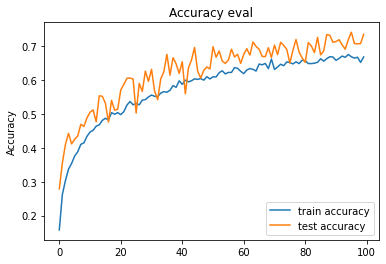

In [ ]:
plot_accuracy(th_history_new_data)

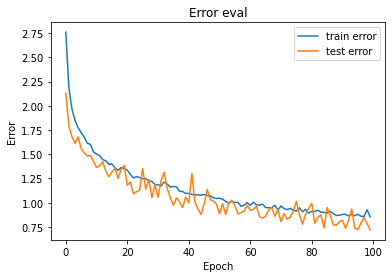

In [ ]:
plot_loss(th_history_new_data)

CNN 

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(th_inputs, th_targets, test_size=0.3,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

sec5_cnn = keras.Sequential()

# st conv layer
sec5_cnn.add(keras.layers.Conv2D(256, (2, 2), activation='relu', input_shape=next_inputs_shape))
sec5_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1) , padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))

# 2nd conv layer
sec5_cnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
sec5_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))

# 3rd conv layer
sec5_cnn.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
sec5_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
sec5_cnn.add(keras.layers.Flatten())
sec5_cnn.add(keras.layers.Dense(16, activation='relu'))
sec5_cnn.add(keras.layers.Dropout(0.3))

# output layer
sec5_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
sec5_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sec5_cnn.summary()

sec5_history_new_data = sec5_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)

(216, 13, 1)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 215, 12, 256)      1280      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 215, 12, 256)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 215, 12, 256)     1024      
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 215, 12, 256)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 213, 10, 128)      295040    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 107,

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(th_inputs, th_targets, test_size=0.2,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

sec5_cnn = keras.Sequential()

# st conv layer
sec5_cnn.add(keras.layers.Conv2D(256, (2, 2), activation='relu', input_shape=next_inputs_shape))
sec5_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))

# 2nd conv layer
sec5_cnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
sec5_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))

# 3rd conv layer
sec5_cnn.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
sec5_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
sec5_cnn.add(keras.layers.Flatten())
sec5_cnn.add(keras.layers.Dense(16, activation='relu'))
sec5_cnn.add(keras.layers.Dropout(0.3))

# output layer
sec5_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.01)
sec5_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sec5_cnn.summary()

sec5_1_history_new_data = sec5_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)

(216, 13, 1)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 215, 12, 256)      1280      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 108, 6, 256)      0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 108, 6, 256)      1024      
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 108, 6, 256)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 106, 4, 128)       295040    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53,

Neural Network 

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(th_inputs, th_targets, test_size=0.3)

sec6_model = keras.Sequential([
    keras.layers.Flatten(input_shape = (th_inputs.shape[1], th_inputs.shape[2])),
    
    #1st hidden layer 
    keras.layers.Dense(512, activation = "relu",  name="layer1"), 
    keras.layers.Dropout(0.3),
    #2nd hidden layer 
    keras.layers.Dense(256, activation = "relu",  name="layer2"), 
    keras.layers.Dropout(0.3),
    #3nd hidden layer 
    keras.layers.Dense(64, activation = "relu",  name="layer3"), 
    keras.layers.Dropout(0.3),
    #output layer 
    keras.layers.Dense(11, activation = "softmax",  name="outputlayer") # labels. (Softmax is for multiclasss, sigmoid for binary classification)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
sec6_model.compile(optimizer=optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"]
)
sec6_model.summary()

sec6_history = sec6_model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=100, 
          batch_size=32)



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 2808)              0         
                                                                 
 layer1 (Dense)              (None, 512)               1438208   
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 layer2 (Dense)              (None, 256)               131328    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 layer3 (Dense)              (None, 64)                16448     
                                                                 
 dropout_22 (Dropout)        (None, 64)               

KeyboardInterrupt: ignored

MFCC with 15 segments ( 2 seconds ), trying CNN with 70%/15%/15%, 0.001% learning rate. 16, 32, 32 (dropout =0.3), 64 (dropout =0.3), 100 epochs. 

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.3)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())
th_model_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

(87, 13, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 85, 11, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 6, 16)        0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 43, 6, 16)        64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 41, 4, 32)         4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 2, 32)        0         
 2D)                                                             
                                          

In [ ]:
history_1 = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)

Epoch 1/100
700/700 [==============================] - 10s 12ms/step - loss: 1.9435 - accuracy: 0.3500 - val_loss: 1.5018 - val_accuracy: 0.4776
Epoch 2/100
700/700 [==============================] - 7s 11ms/step - loss: 1.5630 - accuracy: 0.4671 - val_loss: 1.4048 - val_accuracy: 0.5201
Epoch 3/100
700/700 [==============================] - 5s 7ms/step - loss: 1.4190 - accuracy: 0.5181 - val_loss: 1.2841 - val_accuracy: 0.5662
Epoch 4/100
700/700 [==============================] - 5s 7ms/step - loss: 1.3398 - accuracy: 0.5489 - val_loss: 1.1854 - val_accuracy: 0.5956
Epoch 5/100
700/700 [==============================] - 5s 7ms/step - loss: 1.2789 - accuracy: 0.5641 - val_loss: 1.1484 - val_accuracy: 0.6046
Epoch 6/100
700/700 [==============================] - 4s 6ms/step - loss: 1.2471 - accuracy: 0.5766 - val_loss: 1.1466 - val_accuracy: 0.6136
Epoch 7/100
700/700 [==============================] - 5s 7ms/step - loss: 1.2142 - accuracy: 0.5862 - val_loss: 1.1524 - val_accuracy: 0.6

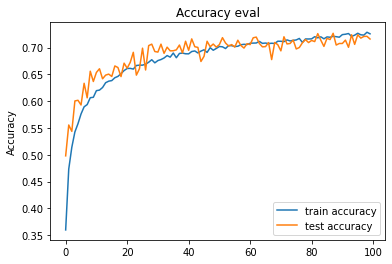

In [ ]:
plot_accuracy(history_1)

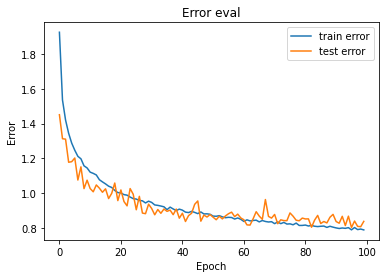

In [ ]:
plot_loss(history_1)

In [ ]:

# save the model to disk
# output = open('model(72/71).pkl', 'wb')

# pick_insert = open('/content/drive/MyDrive/Colab Notebooks/model(72/71).pkl','wb')
# import gc
# import pickle
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

pick_insert = open('/content/drive/mamali.pkl','wb')
pickle.dump(history_1, pick_insert)
pick_insert.close()

# pickle.dump(th_model_cnn, open(mamali, 'wb'))
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

Mounted at /content/drive


OSError: ignored

In [ ]:
# evaluating model
test_loss, test_accuracy = th_model_cnn.evaluate(th_X_test, th_y_test, verbose=2)
print('\nTest accuracy:', test_accuracy)

predict_X = th_X_test[100]
predict_Y = th_y_test[100]

predict_X.shape

predict_X = predict_X[np.newaxis, ...] # array shape (1, 130, 13, 1)

# perform prediction
# print(X_to_predict)
prediction = th_model_cnn.predict(predict_X)
# print(prediction)
# get index with max value
index_predicted = np.argmax(prediction, axis=1)

print("Target: {}, Predicted label: {}".format(predict_Y, index_predicted))

# let's see the genres
for i in index_predicted:
  print("target:",  labels[predict_Y])
  print("predicted:", labels[i])

150/150 - 1s - loss: 0.8174 - accuracy: 0.7281 - 780ms/epoch - 5ms/step

Test accuracy: 0.7280500531196594
Target: 8, Predicted label: [8]


In [ ]:
next_targets

array([ 0,  0,  0, ..., 10, 10, 10])

In [ ]:
df = pd.DataFrame(predict_X)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-324.677643,171.632660,-13.280091,42.372391,15.670492,15.992809,6.270393,11.010396,4.618703,-7.853638,-12.739897,4.661171,3.010840
1,-322.280792,155.274368,-9.958336,39.922695,21.831207,17.970287,5.662805,6.150874,3.916327,-8.796647,-11.299770,7.680173,5.852463
2,-296.648193,124.570236,8.185252,29.442339,31.664001,21.548695,7.103942,-0.020872,4.630404,-7.085770,-6.641536,6.386458,4.188173
3,-274.302032,115.731544,20.255714,22.367203,31.841248,22.588776,4.244648,-0.265239,-2.052029,-6.158319,-1.362402,5.751551,-3.202127
4,-264.150482,109.109535,22.250904,20.674221,27.132450,24.117563,7.075303,8.179565,-8.946896,-8.190316,-2.821103,7.320388,-6.816626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,-298.910614,106.280975,31.920996,30.992025,28.281235,26.680130,12.189566,0.240200,-5.907578,-9.271717,-1.969337,0.119034,-7.932968
83,-290.866852,115.487213,33.255623,26.883934,21.466587,18.290812,14.764830,4.990846,2.552774,-7.670497,-8.947603,-4.957423,-12.072908
84,-274.401367,115.050262,39.578217,20.806616,23.239216,21.172447,16.422871,2.047858,6.600627,-2.397276,-15.116740,-7.185731,-8.269913
85,-272.913361,117.870163,39.555321,24.504681,25.715446,21.830776,10.589582,-1.630363,3.982267,0.498171,-15.611483,-6.736217,-4.184823


Extra training of the same model: 

In [ ]:
history_1 = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=200)

Epoch 1/200
700/700 [==============================] - 8s 11ms/step - loss: 0.7883 - accuracy: 0.7239 - val_loss: 0.8003 - val_accuracy: 0.7230
Epoch 2/200
700/700 [==============================] - 6s 8ms/step - loss: 0.7977 - accuracy: 0.7224 - val_loss: 0.8233 - val_accuracy: 0.7195
Epoch 3/200
700/700 [==============================] - 5s 7ms/step - loss: 0.7863 - accuracy: 0.7266 - val_loss: 0.8663 - val_accuracy: 0.7109
Epoch 4/200
700/700 [==============================] - 5s 7ms/step - loss: 0.7813 - accuracy: 0.7335 - val_loss: 0.8096 - val_accuracy: 0.7272
Epoch 5/200
700/700 [==============================] - 5s 7ms/step - loss: 0.7826 - accuracy: 0.7268 - val_loss: 0.8141 - val_accuracy: 0.7218
Epoch 6/200
700/700 [==============================] - 4s 6ms/step - loss: 0.7811 - accuracy: 0.7272 - val_loss: 0.7976 - val_accuracy: 0.7266
Epoch 7/200
700/700 [==============================] - 5s 7ms/step - loss: 0.7819 - accuracy: 0.7253 - val_loss: 0.9424 - val_accuracy: 0.687

target: hiphop
predicted: hiphop


In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.3)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())
th_model_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.01)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

(87, 13, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 85, 11, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 6, 16)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 43, 6, 16)        64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 41, 4, 32)         4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 2, 32)        0         
 2D)                                                             
                                          

In [ ]:
history_1 = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=60)

Epoch 1/60
700/700 [==============================] - 6s 7ms/step - loss: 1.8564 - accuracy: 0.3738 - val_loss: 1.5331 - val_accuracy: 0.4697
Epoch 2/60
700/700 [==============================] - 5s 7ms/step - loss: 1.5724 - accuracy: 0.4629 - val_loss: 1.5323 - val_accuracy: 0.4868
Epoch 3/60
700/700 [==============================] - 5s 7ms/step - loss: 1.4994 - accuracy: 0.4889 - val_loss: 1.6441 - val_accuracy: 0.4350
Epoch 4/60
700/700 [==============================] - 5s 7ms/step - loss: 1.4752 - accuracy: 0.5010 - val_loss: 1.5117 - val_accuracy: 0.5057
Epoch 5/60
700/700 [==============================] - 5s 7ms/step - loss: 1.4498 - accuracy: 0.5098 - val_loss: 1.4324 - val_accuracy: 0.5014
Epoch 6/60
700/700 [==============================] - 5s 7ms/step - loss: 1.4085 - accuracy: 0.5244 - val_loss: 1.3231 - val_accuracy: 0.5437
Epoch 7/60
700/700 [==============================] - 5s 7ms/step - loss: 1.4069 - accuracy: 0.5260 - val_loss: 1.3374 - val_accuracy: 0.5353
Epoch 

## K-Nearest-Neighbor

In [ ]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

In [ ]:
#define a function to get distance between feature vectors and find neighbors
def getNeighbors(trainingset, instance, k):
    distances = []
    for x in range(len(trainingset)):
        dist = distance(trainingset[x], instance, k) + distance(instance,trainingset[x],k)
        distances.append((trainingset[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [ ]:
#function to identify the nearest neighbors
def nearestclass(neighbors):
    classVote = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
            
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [ ]:
# define a function that will evaluate a model
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == prediction[x]:
            correct += 1
    return 1.0 * correct / len(testSet)

In [ ]:
os.getcwd()

In [ ]:
import librosa, IPython
import librosa.display
file = './Data/genres_original/disco/disco.00031.wav'
signal, sr = librosa.load(file , sr = 22050) 
IPython.display.Audio(signal, rate=sr)

In [ ]:
directory = '/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres_original/'
f = open("my.dat", "wb")
i = 0
for folder in os.listdir(directory):
    #print(folder)
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+"/"+folder):
        #print(file)
        try:
            (rate, sig) = wav.read(directory+"/"+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen = 0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print("Got an exception: ", e, 'in folder: ', folder, ' filename: ', file)
f.close()

In [ ]:
os.getcwd()

In [ ]:
#split dataset into train and test set
dataset = []

def loadDataset(filename, split, trset, teset):
    with open('my.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trset.append(dataset[x])
        else:
            teset.append(dataset[x])

trainingSet = []
testSet = []
loadDataset('my.dat', 0.66, trainingSet, testSet)

In [ ]:
# Make the prediction using KNN(K nearest Neighbors)
length = len(testSet)
predictions = []
for x in range(length):
    predictions.append(nearestclass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

In [ ]:
from collections import defaultdict
results = defaultdict(int)

directory = "./Data/genres_original"

i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [ ]:
pred = nearestclass(getNeighbors(dataset, feature, 5))
print(pred)
print(results[pred])

In [ ]:
print(results)

In [ ]:
th_X_train = tf.math.divide(
   tf.subtract(
      th_X_train, 
      tf.reduce_min(th_X_train)
   ), 
   tf.subtract(
      tf.reduce_max(th_X_train), 
      tf.reduce_min(th_X_train)
   )
)

In [ ]:
th_X_train[0, 0]

<tf.Tensor: shape=(13, 1), dtype=float64, numpy=
array([[0.60684206],
       [0.91673995],
       [0.80374189],
       [0.80932083],
       [0.80926057],
       [0.79217434],
       [0.79904342],
       [0.79676517],
       [0.78971444],
       [0.7892888 ],
       [0.78741729],
       [0.79016806],
       [0.79159379]])>

In [ ]:
th_X_test = tf.math.divide(
   tf.subtract(
      th_X_test, 
      tf.reduce_min(th_X_test)
   ), 
   tf.subtract(
      tf.reduce_max(th_X_test), 
      tf.reduce_min(th_X_test)
   )
)

In [ ]:
th_X_test[0, 0]

<tf.Tensor: shape=(13, 1), dtype=float64, numpy=
array([[0.24161083],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596],
       [0.79374596]])>

In [ ]:
### Great now we gonna try our best model (70% accuracy) with normalized data

In [ ]:
# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
# th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]

In [ ]:
th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

(87, 13, 1)


In [ ]:
th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))


# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))


# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(256, activation = 'relu'))
th_model_cnn.add(keras.layers.Dense(128, activation = 'relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 85, 11, 64)        640       
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 43, 6, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 41, 4, 32)         18464     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 21, 2, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 20, 1, 32)         4128      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 10, 1, 32)      

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)

Epoch 1/100
787/787 [==============================] - 7s 9ms/step - loss: 2.2590 - accuracy: 0.1613 - val_loss: 2.1679 - val_accuracy: 0.2000
Epoch 2/100
787/787 [==============================] - 7s 9ms/step - loss: 2.1334 - accuracy: 0.2122 - val_loss: 2.1419 - val_accuracy: 0.2060
Epoch 3/100
787/787 [==============================] - 7s 9ms/step - loss: 2.1183 - accuracy: 0.2234 - val_loss: 2.1169 - val_accuracy: 0.2219
Epoch 4/100
787/787 [==============================] - 6s 8ms/step - loss: 2.1032 - accuracy: 0.2290 - val_loss: 2.0707 - val_accuracy: 0.2420
Epoch 5/100
787/787 [==============================] - 6s 8ms/step - loss: 2.0491 - accuracy: 0.2489 - val_loss: 1.9815 - val_accuracy: 0.2741
Epoch 6/100
787/787 [==============================] - 6s 8ms/step - loss: 1.9773 - accuracy: 0.2818 - val_loss: 1.9247 - val_accuracy: 0.2994
Epoch 7/100
787/787 [==============================] - 6s 8ms/step - loss: 1.9466 - accuracy: 0.2947 - val_loss: 1.9013 - val_accuracy: 0.3218

In [ ]:
th_input_shape

(87, 13, 1)

In [ ]:
import tensorflow_hub as hub
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
                   trainable=False,
                   input_shape = (87, 13, 1))
m = tf.keras.Sequential([
    feature_extractor_layer,  # Can be True, see below.
    tf.keras.layers.Dense(11, activation='softmax')])

ValueError: ignored

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
m.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
m_history = m.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)

Epoch 1/100


ValueError: ignored

In [ ]:
model_1d = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, activation = 'relu', input_shape = (87 , 13)),
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, activation = 'relu'),
  tf.keras.layers.MaxPooling1D(pool_size = 2, strides= 1),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, activation = 'relu'),
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, activation = 'relu'),
  tf.keras.layers.MaxPooling1D(pool_size = 2, strides= 1),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, activation = 'relu'),
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, activation = 'relu'),
  tf.keras.layers.MaxPooling1D(pool_size = 2, strides= 1),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, activation = 'relu'),
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, activation = 'relu'),
  tf.keras.layers.MaxPooling1D(pool_size = 2, strides= 1),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(11, activation='softmax')

])

In [ ]:
model_1d.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
model_1_history = model_1d.fit(test_test_X, th_y_train, validation_data=(test_val_X , th_y_test), batch_size=32, epochs=100)

Epoch 1/100


ValueError: ignored

In [ ]:
test_test_X = tf.reshape(tensor = th_X_train, shape = (25156, 87, 13))
test_val_X = tf.reshape(tensor = th_X_test, shape = (6290, 87, 13))

In [ ]:
th_X_test.shape

TensorShape([6290, 87, 13, 1])